In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [5]:
# Load MNIST dataset

# https://yann.lecun.com/exdb/mnist/
# https://pytorch.org/docs/stable/data.html#module-torch.utils.data
# https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html

train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transform, download=True)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 54.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.07MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.03MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



2
3
torch.Size([1, 28, 28])
Image label is : 5


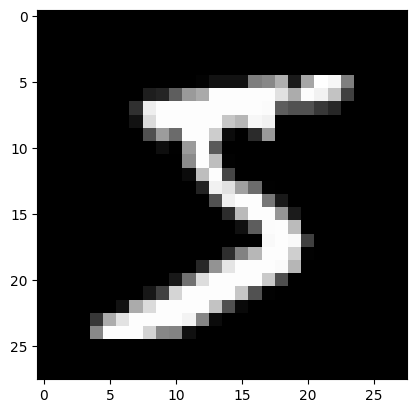

In [6]:
print(len(train_dataset.__getitem__(0)))
print(len(train_dataset.__getitem__(0)[0].shape))
print(train_dataset.__getitem__(0)[0].shape)
print(f"Image label is : {train_dataset.__getitem__(0)[1]}")
plt.imshow(train_dataset.__getitem__(0)[0].squeeze(), cmap="grey")

<class 'torchvision.datasets.mnist.MNIST'>
<class 'torch.Tensor'>
torch.Size([1, 28, 28])


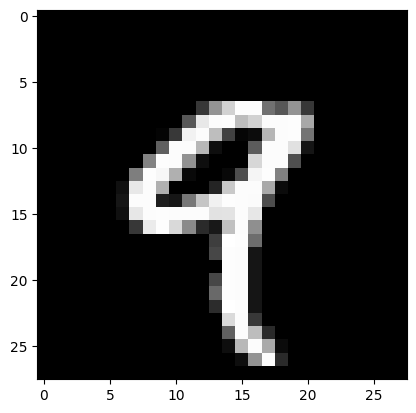

In [7]:
print(type(train_dataset))
print(type(train_dataset[0][0]))
print(train_dataset[0][0].shape)
plt.imshow(train_dataset[4][0].squeeze(), cmap="grey")

In [8]:
batch_size = 32

# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        # self.lrn = nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2)

    def forward(self, x):
        x = x.reshape(-1, 28 * 28)  # Flatten the image
        # x = x.view(-1, 28 * 28)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
learning_rate = 0.001

In [11]:
model = DigitClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# Training function
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

In [13]:
# Validation function
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        batch = 1
        for images, labels in loader:
            print(f"Current batch : {batch}")
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            print(f"Running loss : {running_loss}")
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            batch += 1

    epoch_loss = running_loss / batch
    accuracy = correct / total
    return epoch_loss, accuracy

In [14]:
num_epochs = 2

In [15]:
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Current batch : 1
Running loss : 0.21660874783992767
Current batch : 2
Running loss : 0.3538558632135391
Current batch : 3
Running loss : 0.8453676551580429
Current batch : 4
Running loss : 1.1694269627332687
Current batch : 5
Running loss : 1.2165269665420055
Current batch : 6
Running loss : 1.3067271150648594
Current batch : 7
Running loss : 1.9478206671774387
Current batch : 8
Running loss : 2.143846247345209
Current batch : 9
Running loss : 2.2535860501229763
Current batch : 10
Running loss : 2.377680044621229
Current batch : 11
Running loss : 2.8951991014182568
Current batch : 12
Running loss : 2.944855898618698
Current batch : 13
Running loss : 3.3308252692222595
Current batch : 14
Running loss : 3.452675387263298
Current batch : 15
Running loss : 3.690966561436653
Current batch : 16
Running loss : 3.87991663813591
Current batch : 17
Running loss : 4.272352427244186
Current batch : 18
Running loss : 4.4795780926942825
Current batch : 19
Running loss : 4.727942422032356
Current ba

In [16]:
# Testing
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Current batch : 1
Running loss : 0.12863057851791382
Current batch : 2
Running loss : 0.16475041955709457
Current batch : 3
Running loss : 0.2156970128417015
Current batch : 4
Running loss : 0.2597246579825878
Current batch : 5
Running loss : 0.3857152424752712
Current batch : 6
Running loss : 0.4123117160052061
Current batch : 7
Running loss : 0.4551591407507658
Current batch : 8
Running loss : 0.6955830734223127
Current batch : 9
Running loss : 0.8553344737738371
Current batch : 10
Running loss : 0.9942561816424131
Current batch : 11
Running loss : 1.24675346724689
Current batch : 12
Running loss : 1.417587561532855
Current batch : 13
Running loss : 1.496516963467002
Current batch : 14
Running loss : 1.7074987050145864
Current batch : 15
Running loss : 1.9512949641793966
Current batch : 16
Running loss : 2.1752763148397207
Current batch : 17
Running loss : 2.2679498996585608
Current batch : 18
Running loss : 2.5065799858421087
Current batch : 19
Running loss : 2.7163455989211798
Curr

In [17]:
# Save the model
torch.save(model.state_dict(), "mnist_digit_classifier.pth")
print("Model saved as mnist_digit_classifier.pth")

Model saved as mnist_digit_classifier.pth


# Model Inference

In [18]:
# Load the model
loaded_model = DigitClassifier().to(device)
loaded_model.load_state_dict(torch.load("mnist_digit_classifier.pth"))
loaded_model.eval()
print("Model loaded for inference.")

Model loaded for inference.


<ipython-input-18-22cd8279ff80>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("mnist_digit_classifier.pth"))


In [19]:
# Inference
def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        _, predicted = output.max(1)
    return predicted.item()

In [20]:
# Function to preprocess the image
def preprocess_image(image):

    image = cv2.bitwise_not(image)

    transform = transforms.Compose([
        transforms.ToPILImage(),             # Convert to PIL image
        # https://pytorch.org/vision/0.8/transforms.html

        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((28, 28)),        # Resize to match MNIST input size
        transforms.ToTensor(),              # Convert to tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize
    ])
    image = transform(image)  # Apply transforms
    # image = image.unsqueeze(0)  # Add batch dimension (1, 1, 28, 28)
    return image

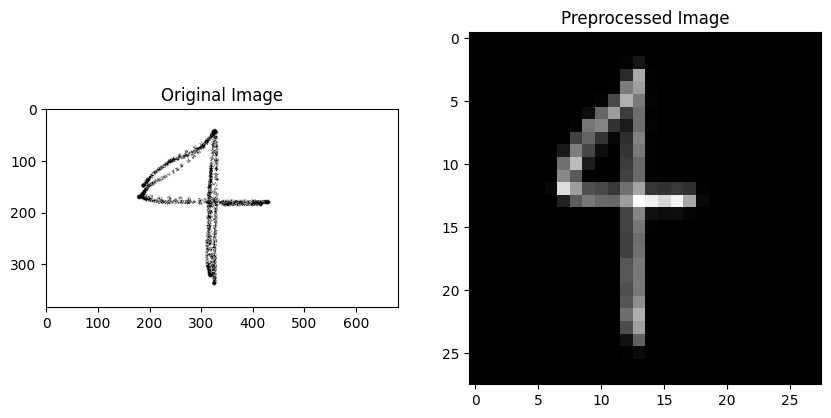

Predicted Label: 1


In [ ]:
import cv2

image = cv2.imread("/content/MS Paint _ Microsoft Paint Online.png")

# Preprocess the image
preprocessed_image = preprocess_image(image)

# Visualize the original and preprocessed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Show the original image in RGB
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image.squeeze(), cmap='grey')  # Show the preprocessed image
plt.title("Preprocessed Image")
plt.show()

# Predict the label
predicted_label = predict(model, preprocessed_image)
print(f"Predicted Label: {predicted_label}")


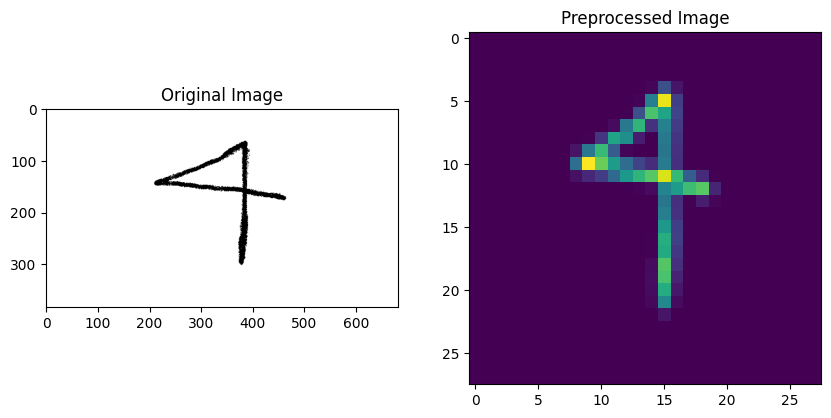

Predicted Label: 1


In [ ]:
import cv2

image = cv2.imread("/content/four.png")

# Preprocess the image
preprocessed_image = preprocess_image(image)

# Visualize the original and preprocessed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Show the original image in RGB
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image.squeeze())  # Show the preprocessed image
plt.title("Preprocessed Image")
plt.show()

# Predict the label
predicted_label = predict(model, preprocessed_image)
print(f"Predicted Label: {predicted_label}")


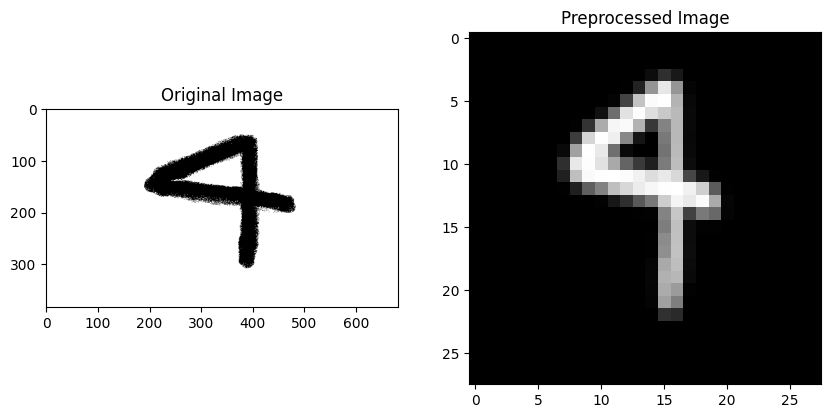

Predicted Label: 9


In [ ]:
import cv2

image = cv2.imread("/content/four_new.png")

# Preprocess the image
preprocessed_image = preprocess_image(image)

# Visualize the original and preprocessed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Show the original image in RGB
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image.squeeze(), cmap='grey')  # Show the preprocessed image
plt.title("Preprocessed Image")
plt.show()

# Predict the label
predicted_label = predict(model, preprocessed_image)
print(f"Predicted Label: {predicted_label}")


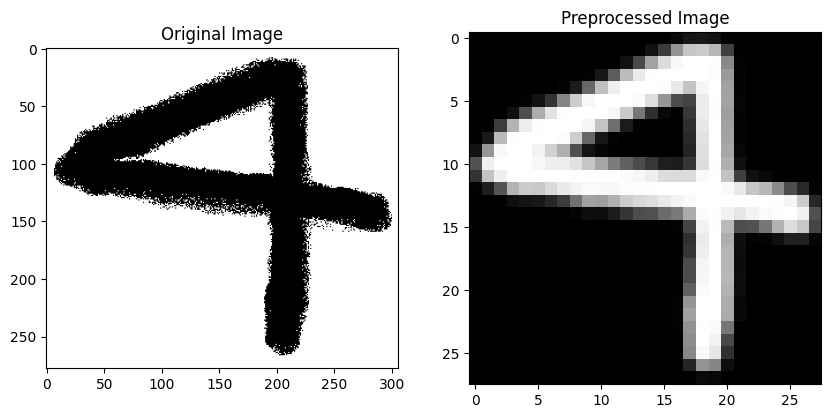

Predicted Label: 7


In [ ]:
import cv2

image = cv2.imread("/content/four_new_resized.png")

# Preprocess the image
preprocessed_image = preprocess_image(image)

# Visualize the original and preprocessed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Show the original image in RGB
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image.squeeze(), cmap='grey')  # Show the preprocessed image
plt.title("Preprocessed Image")
plt.show()

# Predict the label
predicted_label = predict(model, preprocessed_image)
print(f"Predicted Label: {predicted_label}")


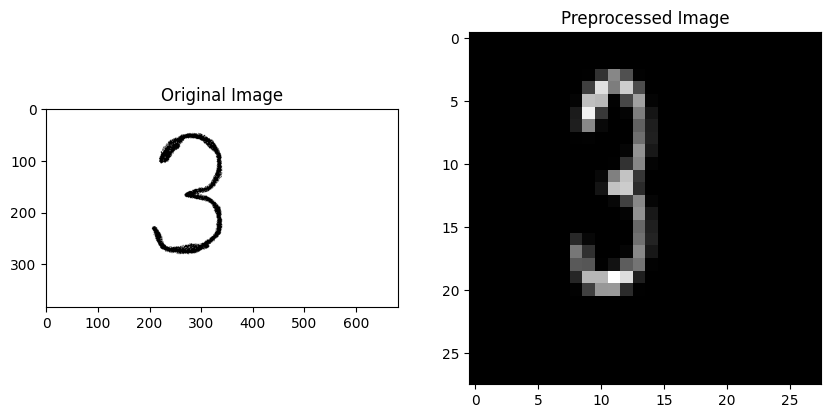

Predicted Label: 2


In [ ]:
import cv2

image = cv2.imread("/content/three.png")

# Preprocess the image
preprocessed_image = preprocess_image(image)

# Visualize the original and preprocessed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Show the original image in RGB
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image.squeeze(), cmap='grey')  # Show the preprocessed image
plt.title("Preprocessed Image")
plt.show()

# Predict the label
predicted_label = predict(model, preprocessed_image)
print(f"Predicted Label: {predicted_label}")


# CNN

In [21]:
class CNN(nn.Module):

    # Define all different types of layers we are going to use in model here.
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Output: 32x28x28
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                 # Output: 32x14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # Output: 64x14x14
        self.fc1 = nn.Linear(64 * 7 * 7, 128)                            # Fully connected layer
        self.fc2 = nn.Linear(128, 10)                                    # 10 classes for digits (0-9)

    # Define sequence of layers as model architect.
    def forward(self, x):
        # 1x28x28
        x = self.conv1(x) # 32×28×28
        x = self.relu(x)

        x = self.pool(x) # 32×14×14
        x = self.conv2(x) # 64×14×14
        x = self.relu(x)
        x = self.pool(x) # MaxPool2
        x = x.view(x.size(0), -1)  # Flatten the tensor # 3136
        x = self.fc1(x) # 128
        x = self.relu(x)
        x = self.fc2(x) # 10
        return x


In [22]:
# Model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")


Epoch [1/50], Loss: 0.1550
Epoch [2/50], Loss: 0.0482
Epoch [3/50], Loss: 0.0336
Epoch [4/50], Loss: 0.0233
Epoch [5/50], Loss: 0.0184
Epoch [6/50], Loss: 0.0140
Epoch [7/50], Loss: 0.0128
Epoch [8/50], Loss: 0.0100
Epoch [9/50], Loss: 0.0090
Epoch [10/50], Loss: 0.0066
Epoch [11/50], Loss: 0.0068
Epoch [12/50], Loss: 0.0072
Epoch [13/50], Loss: 0.0055
Epoch [14/50], Loss: 0.0057
Epoch [15/50], Loss: 0.0063
Epoch [16/50], Loss: 0.0022
Epoch [17/50], Loss: 0.0055
Epoch [18/50], Loss: 0.0050
Epoch [19/50], Loss: 0.0042
Epoch [20/50], Loss: 0.0033
Epoch [21/50], Loss: 0.0052
Epoch [22/50], Loss: 0.0036
Epoch [23/50], Loss: 0.0052
Epoch [24/50], Loss: 0.0021
Epoch [25/50], Loss: 0.0049
Epoch [26/50], Loss: 0.0037
Epoch [27/50], Loss: 0.0021
Epoch [28/50], Loss: 0.0047
Epoch [29/50], Loss: 0.0028
Epoch [30/50], Loss: 0.0020
Epoch [31/50], Loss: 0.0032
Epoch [32/50], Loss: 0.0024
Epoch [33/50], Loss: 0.0040
Epoch [34/50], Loss: 0.0026
Epoch [35/50], Loss: 0.0035
Epoch [36/50], Loss: 0.0033
E

In [23]:
# Save the model
torch.save(model.state_dict(), "mnist_digit_classifier_cnn.pth")
print("Model saved as mnist_digit_classifier_cnn.pth")

Model saved as mnist_digit_classifier_cnn.pth


In [ ]:
# Load the model
loaded_model = CNN().to(device)
loaded_model.load_state_dict(torch.load("mnist_digit_classifier_cnn.pth"))
loaded_model.eval()
print("Model loaded for inference.")

Model loaded for inference.


<ipython-input-22-b562eecac6a9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("mnist_digit_classifier_cnn.pth"))


In [24]:
from PIL import Image

In [25]:
# Preprocessing function for a single image
def preprocess_image(image_path):


    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),  # Ensure image has one channel
        transforms.Resize((28, 28)),                 # Resize to 28x28 (same as MNIST images)
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))         # Normalize with the same mean and std as training
    ])

    image = cv2.imread(image_path)
    image = cv2.bitwise_not(image)

    return transform(image).unsqueeze(0)  # Add batch dimension

In [26]:
# Perform inference
def predict_image(image_path):
    # Preprocess the image
    image_tensor = preprocess_image(image_path)

    # Perform forward pass
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

In [27]:
import cv2

In [ ]:
predicted_label = predict_image("/content/four.png")
print(f"Predicted Label: {predicted_label}")

predicted_label = predict_image("/content/four_new.png")
print(f"Predicted Label: {predicted_label}")

predicted_label = predict_image("/content/four_new_resized.png")
print(f"Predicted Label: {predicted_label}")

predicted_label = predict_image("/content/three.png")
print(f"Predicted Label: {predicted_label}")

Predicted Label: 7
Predicted Label: 9
Predicted Label: 7
Predicted Label: 3


# Different ways to create a architecture

# Type 1 : Use Adaptive Pooling

In [28]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Output: 32x28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 32x14x14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Output: 64x14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                  # Output: 64x7x7
        )

        # Adaptive pooling to ensure fixed output size (e.g., 64x1x1)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output: 64x1x1

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                # Flatten for linear layers
            nn.Linear(64, 128),          # Map pooled features to 128 nodes
            nn.ReLU(),
            nn.Linear(128, 10)           # Output 10 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)          # Pass through convolutional layers
        x = self.global_pool(x)          # Adaptive pooling
        x = self.fc_layers(x)            # Pass through fully connected layers
        return x


# Type 2 : Use PyTorch’s Sequential API

In [29]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)


# Type 3 : Use Dynamic Calculation

In [30]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = None  # Placeholder for first fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Fixed output size for 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        if self.fc1 is None:
            # Dynamically define fc1 based on input dimensions
            self.fc1 = nn.Linear(x.view(x.size(0), -1).size(1), 128)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
